# Overview of Results in the Atlas Dataset

August 2019, Stephen Strowes, CAIDA / RIPE NCC



## Overview

The RIPE Atlas platform is a network measurement platform offering general access to a set of predefined network measurement types from many vantage points.

The platform runs measurements of different types, including:

* **Built-in measurements**: ongoing measurements run by all probes on the platform to various stable targets. The set of specifications includes various ping, traceroute, HTTP, DNS, and SSL measurements. The full set of built-in measurements [is described here](https://atlas.ripe.net/docs/built-in/).
* **Ongoing topology measurements**: One of the built-in measurements defined above specifically aims for topological breadth by sending traceroutes to "every routed prefix yesterday" over both IPv4 and IPv6. Every Atlas probe resolves the same DNS record which round-robins through all the potential ‘.1’ or ‘::1’ addresses given the set of routed prefixes.
* **Anchoring measurements**, ongoing measurements that target Atlas anchors with ping, traceroute, and HTTP over IPv4 and IPv6. These are further subdivided into the full-mesh of 450 anchors running measurements to each other, and a few hundred other probes measuring each anchor.
* **User-defined measurements (UDMs)**, permitted from arbitrary origins to arbitrary targets for most types of measurement. HTTP measurements are restricted to very few users.

The measurements are delineated in different ways:

* **Measurement Specification IDs**: Every measurement specification has a unique integer ID. Measurement IDs less than 1,000,000 are built-ins; all user-defined measurements have IDs greater than 1,000,000.
* **Anchoring measurements** are generated with specification IDs higher than 1,000,000 but can be identified from the tags on the measurements themselves. These can be described [with some work via the API](https://atlas.ripe.net/docs/api/v2/reference/#!/anchor-measurements/Anchor_Measurement_List_GET) or in the [daily measurement "meta" dumps](https://ftp.ripe.net/ripe/atlas/measurements/).


## Target Diversity

## Source Diversity

Topology measurements: Given the lack of control with this method, different sources are likely to be used for the same target over time if the target is repeatedly present in the list.


## List of dimensions

* Public measurements
  * Topology
  * Other Built-ins
  * Anchoring
  * User-defined
* All measurements
  * Topology
  * Other Built-ins
  * Anchoring
  * User-defined


Can I define a table that includes:
* hour
* prb_id
* af
* msm_id
* msm_class
* public/private
* oneoff
* src_address
* dst_address
* dst_name
* count

* Target diversity for each of the above

* Later: ASN diversity
* Later: IPv4 and IPv6


### Public vs Private

From 2019-06-01 00:00:00 through 2019-08-26 18:59:59:
* 8.42bn traceroute results total


## Composition of Results Corpus

Want: an overview of which results types contribute

In [1]:
%load_ext google.cloud.bigquery

In [93]:
%%bigquery public_private

SELECT
  ts,
  af,
  public,
  msm_class,
  COUNT(*) as count
FROM
  `data-test-194508.atlas_results_meta.msm_types`
GROUP BY
  ts, af, public, msm_class, public
ORDER BY
  ts ASC

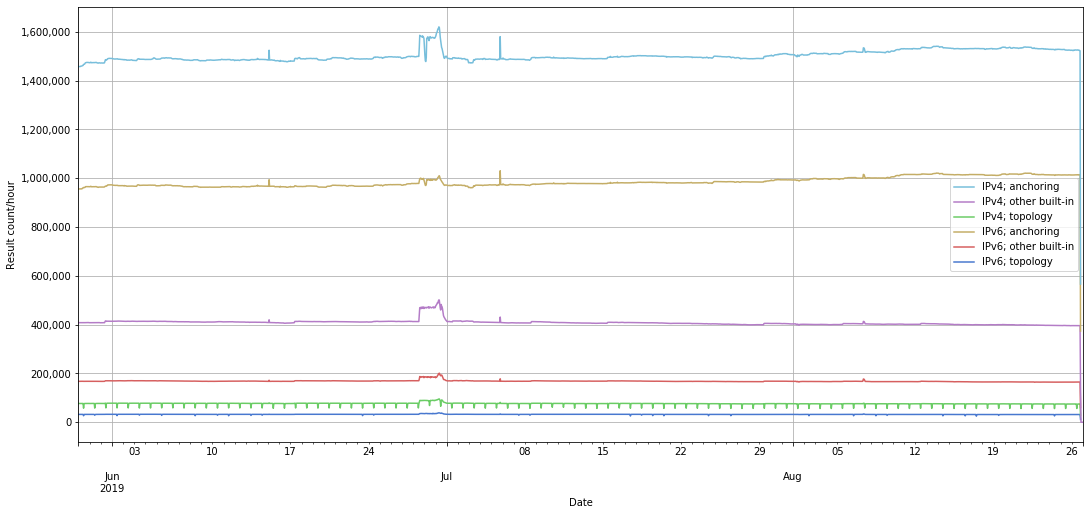

In [123]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

#------------------------------------------------------------------------------
# Plot built-ins, IPv6/4
for af in [6, 4]:
        grp   = public_private[((public_private['msm_class'] == "topology*.dyndns.atlas.ripe.net UDP") | (public_private['msm_class'] == "topology*.dyndns.atlas.ripe.net ICMP")) & (public_private['af'] == af)]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; topology"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

        #------------------------------------------------------------------------------
for af in [6, 4]:
        grp   = public_private[
            ((public_private['msm_class'] == "*.root-servers.net") | (public_private['msm_class'] == "ctr-*.atlas.ripe.net")) &
            (public_private['af'] == af)
        ]
        
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; other built-in"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
        
for af in [6, 4]:
        grp   = public_private[
            ((public_private['msm_class'] == "anchoring (probes)") | (public_private['msm_class'] == "anchoring (mesh)")) &
            (public_private['af'] == af)
        ]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; anchoring"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
        

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


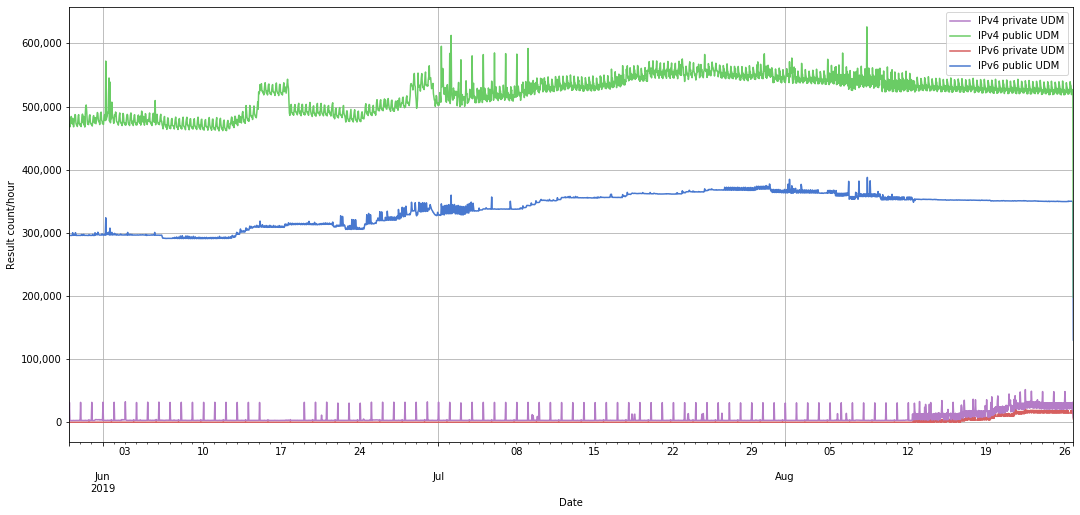

In [122]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

# Plot UDMs
for p in [ True, False ]:
    for af in [ 6, 4 ]:
        grp   = public_private[(public_private['msm_class'] == "user-defined") & (public_private['public'] == p) & (public_private['af'] == af) ]
        #    grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        if p == True:
            label = "IPv" + str(af) +" public UDM"
        else:
            label = "IPv" + str(af) +" private UDM"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


## Results per measurement category



In [29]:
%%bigquery msm_class_result_counts
SELECT * FROM `data-test-194508.sds_test.msm_class_result_counts` ORDER BY ts

In [40]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.dates as dates
import matplotlib.pyplot as plt

grp   = msm_class_result_counts[
    ((msm_class_result_counts['msm_class'] == "user-defined")) &
    (msm_class_result_counts['af'] == 4)]


# Target Diversity

The above refers to the number of measurement results (i.e., the number of traceroutes returned); it says nothing of the targets measured or the hops travered.

First, it's easy to count the number of targets each type of measurement used:

In [128]:
%%bigquery target_counts

SELECT
  ts,
  af,
  msm_class,
  public,
  COUNT(DISTINCT dst_address) as count
FROM
  `data-test-194508.atlas_results_meta.msm_types`
GROUP BY
  ts, af, public, msm_class
ORDER BY ts


Let's break this down as before, into measurements run by the system (built-ins and anchoring measurements), followed by user-defined measurements, in the form of time-series:


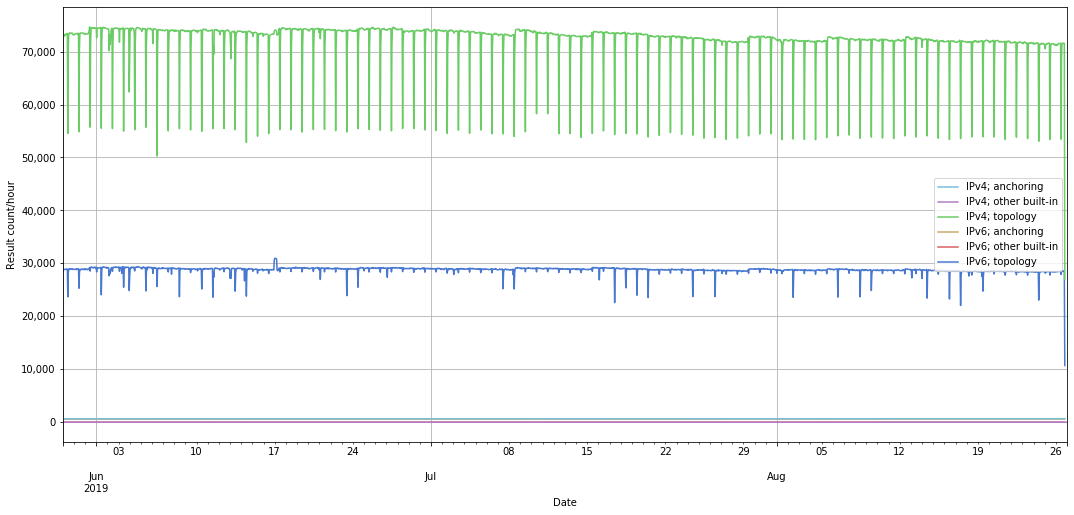

In [130]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

#------------------------------------------------------------------------------
# Plot built-ins, IPv6/4
for af in [6, 4]:
        grp   = target_counts[((target_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net UDP") | (target_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net ICMP")) & (target_counts['af'] == af)]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; topology"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

        #------------------------------------------------------------------------------
for af in [6, 4]:
        grp   = target_counts[
            ((target_counts['msm_class'] == "*.root-servers.net") | (target_counts['msm_class'] == "ctr-*.atlas.ripe.net")) &
            (target_counts['af'] == af)
        ]
        
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; other built-in"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
        
for af in [6, 4]:
        grp   = target_counts[
            ((target_counts['msm_class'] == "anchoring (probes)") | (target_counts['msm_class'] == "anchoring (mesh)")) &
            (target_counts['af'] == af)
        ]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; anchoring"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
 
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


Although the topology measurements generate relatively few results, the range of targets is (by definition), large: up to around 75,000 distinct IPv4 addresses per hour, and up to 30,000 distinct IPv6 addresses per hour. The other built-in measurements target very specific addresses, and so all cluster towards the bottom of the y-axis.


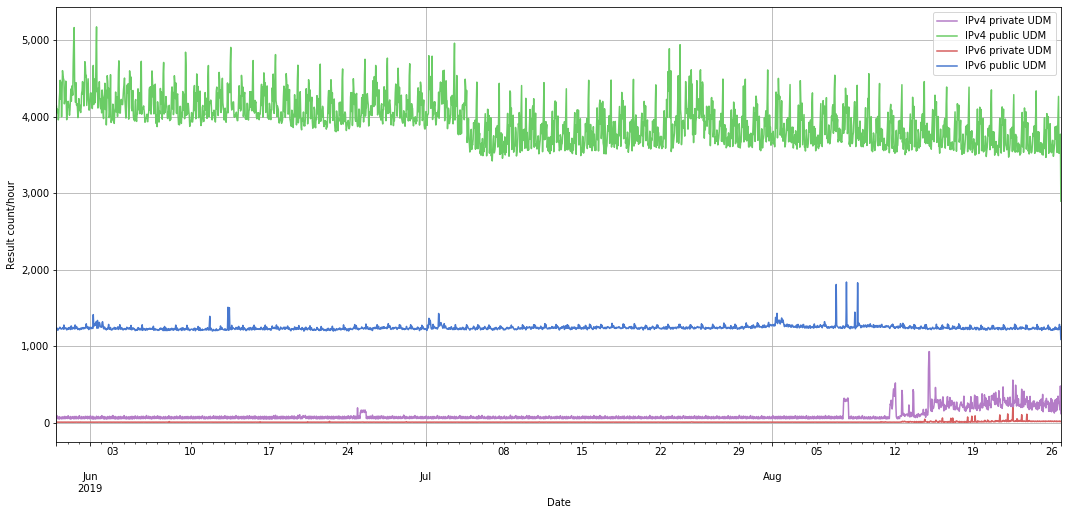

In [129]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

# Plot UDMs
for p in [ True, False ]:
    for af in [ 6, 4 ]:
        grp   = target_counts[(target_counts['msm_class'] == "user-defined") & (target_counts['public'] == p) & (target_counts['af'] == af) ]
        #    grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        if p == True:
            label = "IPv" + str(af) +" public UDM"
        else:
            label = "IPv" + str(af) +" private UDM"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


User-defined measurements are quite different: there appears to be distinct daily patterns, in particular in the IPv4 measurements, and the number of distinct IPv4 targets observed is around 4,000 per hour. The volume of results returned from measurements is quite stable, in particular in the IPv6 case.


### Target ASNs

In [134]:
%%bigquery atlas_asn_counts

SELECT *
FROM `data-test-194508.atlas_results_meta.msm_types_asn_origins`

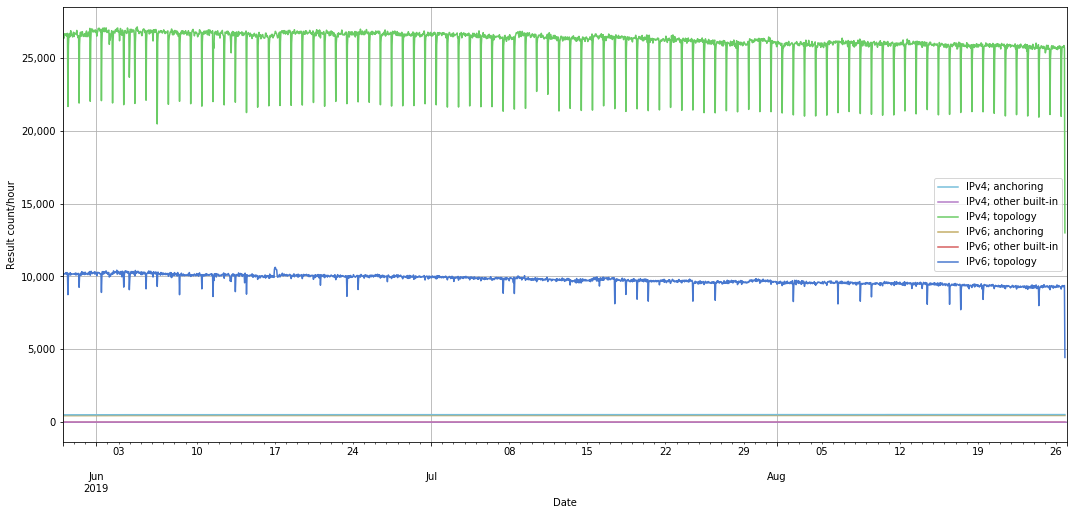

In [136]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

#------------------------------------------------------------------------------
# Plot built-ins, IPv6/4
for af in [6, 4]:
        grp   = atlas_asn_counts[((atlas_asn_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net UDP") | (atlas_asn_counts['msm_class'] == "topology*.dyndns.atlas.ripe.net ICMP")) & (atlas_asn_counts['af'] == af)]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; topology"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

        #------------------------------------------------------------------------------
for af in [6, 4]:
        grp   = atlas_asn_counts[
            ((atlas_asn_counts['msm_class'] == "*.root-servers.net") | (atlas_asn_counts['msm_class'] == "ctr-*.atlas.ripe.net")) &
            (atlas_asn_counts['af'] == af)
        ]
        
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; other built-in"
        #print(label)
        #print(grp)
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
        
for af in [6, 4]:
        grp   = atlas_asn_counts[
            ((atlas_asn_counts['msm_class'] == "anchoring (probes)") | (atlas_asn_counts['msm_class'] == "anchoring (mesh)")) &
            (atlas_asn_counts['af'] == af)
        ]
        grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        label = "IPv" + str(af) + "; anchoring"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)
 
ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


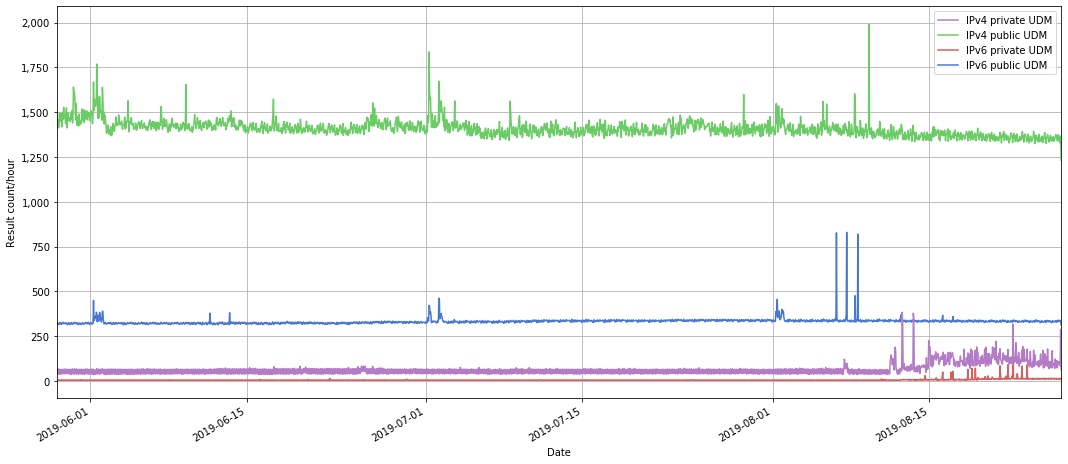

In [135]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [18, 8]
fig, ax = plt.subplots()

# Plot UDMs
for p in [ True, False ]:
    for af in [ 6, 4 ]:
        grp   = atlas_asn_counts[(atlas_asn_counts['msm_class'] == "user-defined") & (atlas_asn_counts['public'] == p) & (atlas_asn_counts['af'] == af) ]
        #    grp = grp[['ts','count']].groupby(["ts"]).sum().reset_index()
        if p == True:
            label = "IPv" + str(af) +" public UDM"
        else:
            label = "IPv" + str(af) +" private UDM"
        ax    = grp.plot(ax=ax, kind='line', x='ts', y='count', label=label)

ax.grid(True)
ax.set_xlabel('Date')
ax.set_ylabel('Result count/hour')
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
)

handles, labels = ax.get_legend_handles_labels()
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels, loc='best')
plt.show()


**To fix**:

the dip map not be fewer targets, but is more likely because I'm using an old routing table for the whole thing.

In [ ]:
**To add**:

* How many results come in per measurement?
* How many probes generate results per measurement?

In [ ]:
%%bigquery v6_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv6"

In [4]:
%%bigquery v4_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv4"

In [5]:
%%bigquery v6_msm_types

SELECT *
FROM atlas_results_meta.msm_types
WHERE SUBSTR(msm_type,0,4) = "IPv6"

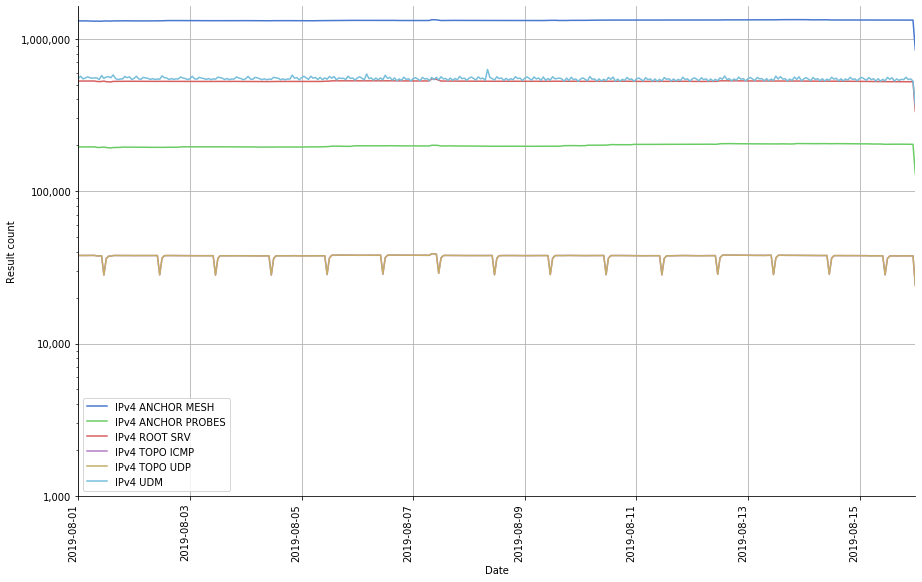

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
fig, ax = plt.subplots()

for key, grp in v4_msm_types.groupby(['msm_type']):
    ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

    
ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

plt.show()


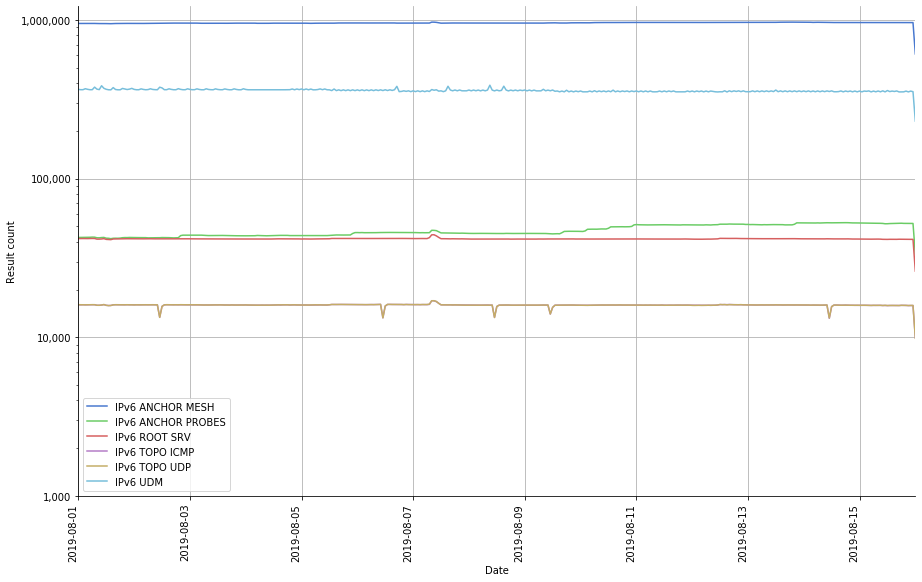

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mplotlib

plt.rcParams['figure.figsize'] = [15, 10]
plt.style.use('seaborn-muted')
fig, ax = plt.subplots()

for key, grp in v6_msm_types.groupby(['msm_type']):
    ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

ax.set_yscale('log')
ax.set_ylabel('Result count')

ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
#plt.box(False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

plt.show()


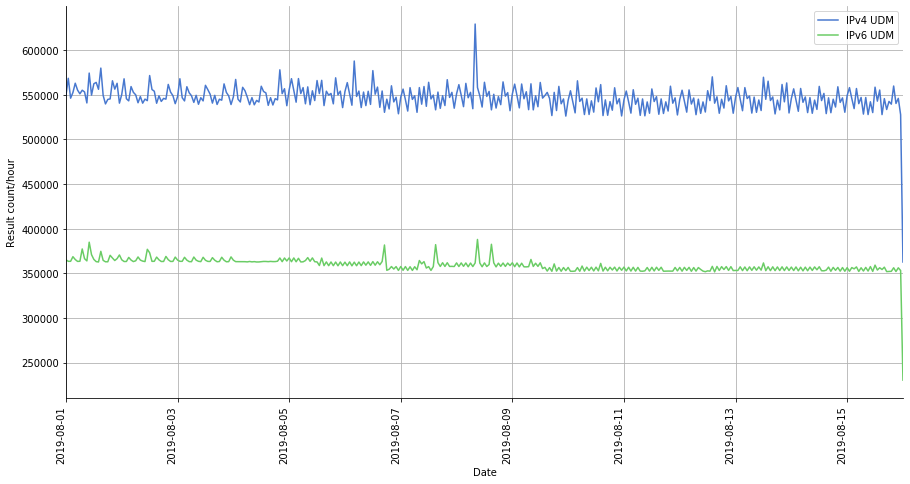

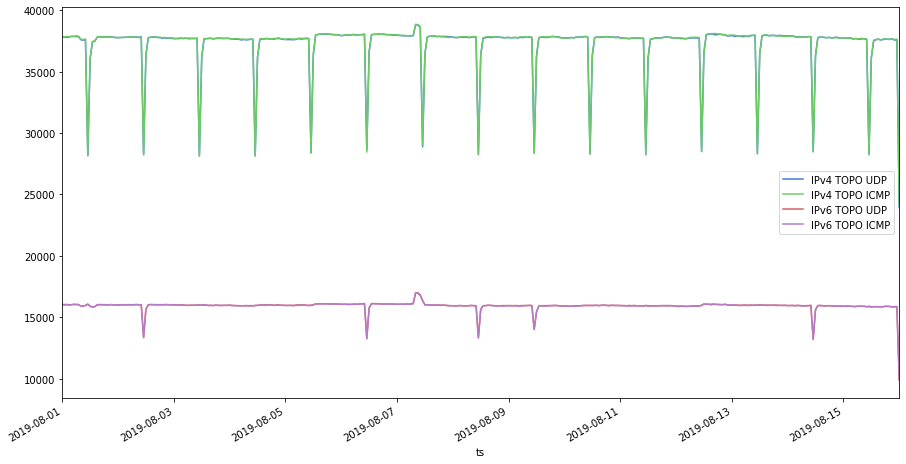

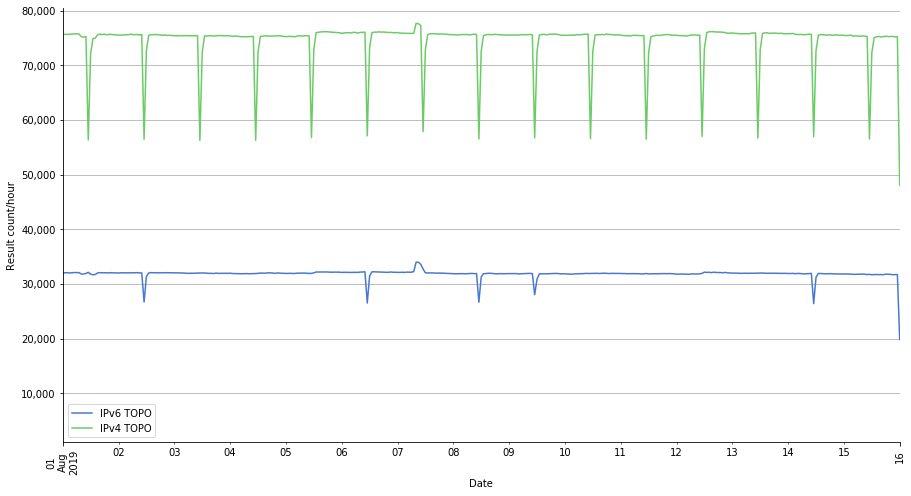

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]
plt.style.use('seaborn-muted')
fig, ax = plt.subplots()

#--------------------------------------------------

key = 'IPv4 UDM'
grp = v4_msm_types[v4_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

key = 'IPv6 UDM'
grp = v6_msm_types[v6_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

ax.set_ylabel('Result count/hour')
ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#--------------------------------------------------

key = 'IPv4 TOPO UDP'
grp = v4_msm_types[v4_msm_types['msm_type'] == key]
ax = grp.plot(kind='line', x='ts', y='count', label=key)

key = 'IPv4 TOPO ICMP'
grp = v4_msm_types[v4_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

key = 'IPv6 TOPO UDP'
grp = v6_msm_types[v6_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

key = 'IPv6 TOPO ICMP'
grp = v6_msm_types[v6_msm_types['msm_type'] == key]
ax = grp.plot(ax=ax, kind='line', x='ts', y='count', label=key)

#---------------------

a = v6_msm_types[v6_msm_types['msm_type'] == 'IPv6 TOPO UDP']
a = a.drop(columns="msm_type")
b = v6_msm_types[v6_msm_types['msm_type'] == 'IPv6 TOPO ICMP']
b = b.drop(columns="msm_type")
c = a.set_index("ts").add(b.set_index("ts")).reset_index()

ax = c.plot(kind='line', x='ts', y='count', label='IPv6 TOPO')

a = v4_msm_types[v4_msm_types['msm_type'] == 'IPv4 TOPO UDP']
a = a.drop(columns="msm_type")
b = v4_msm_types[v4_msm_types['msm_type'] == 'IPv4 TOPO ICMP']
b = b.drop(columns="msm_type")
c = a.set_index("ts").add(b.set_index("ts")).reset_index()

ax = c.plot(ax=ax, kind='line', x='ts', y='count', label='IPv4 TOPO')



#ax.set_yscale('log')
ax.set_ylabel('Result count/hour')
ax.grid(True)
plt.xticks(rotation=90)
ax.set_xlabel('Date')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


ax.set_ylim(bottom=1000)
ax.get_yaxis().set_major_formatter(
    mplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.legend(loc='best')

plt.show()
